In [2]:
import numpy as np
from numba import jit
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import math
from scipy.stats import norm
import random
from tqdm import tqdm

## Part II: Estimation of Sensitivities in MC

In [1]:
def Delta_Analytical_Call(S, K, r, sigma, tau):
    d1 = (math.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * math.sqrt(tau))
    return norm.cdf(d1)

def Delta_Analytical_Digital(S, K, r, sigma, tau):
    d2 = (math.log(S/K) + (r-0.5*sigma**2)*tau) / (sigma * math.sqrt(tau))
    numerator = (math.e**(-r * tau)) * norm.pdf(d2) 
    denomenator = sigma * S * math.sqrt(tau)
    
    return numerator/denomenator

In [3]:
@jit(nopython=True, fastmath=True, parallel=False)
def European_Call(T, K, r, S, sigma, trials, z):
    '''
    This function calculates the value of an European Call option
    Arguments: maturity, strike price, interest rate, stock price, volaility, number of trials
    Returns: Array of size trial with values of european puts
    '''
    
    S_adjust = S * np.exp(r - (0.5 * sigma**2)*T)
    payoff_array = np.zeros(trials)

    for i in range(trials):
        S_cur = S_adjust * np.exp(sigma*np.sqrt(T)*z[i])
        
        if S_cur-K > 0:
            payoff_array[i] = (S_cur-K)*np.exp(-r*T)
        else:
            payoff_array[i] = 0

    return np.mean(payoff_array)


@jit(nopython=True, fastmath=True, parallel=False)
def Digital_Call(T, K, r, S, sigma, trials, z):
    
    S_adjust = S * np.exp(r - (0.5 * sigma**2)*T)
    payoff_array = np.zeros(trials)
    
    for i in range(trials):
        S_cur = S_adjust * np.exp(sigma*np.sqrt(T)*z[i])
        
        if S_cur > K:
            payoff_array[i] = 1 * math.e**(-r*T)
        else:
            payoff_array[i] = 0

    return np.mean(payoff_array)

In [4]:
def get_delta_call(kwargs, S, e, seed=None):
    z=np.zeros(kwargs['trials'])
    for i in range(kwargs['trials']):
        z[i] = np.random.normal()
        
    kwargs['z'] = z   
    kwargs['S'] = S
    
    V = European_Call(**kwargs)
    
    if not seed:
        for i in range(kwargs['trials']):
            z[i] = random.normalvariate(0, 1)
        kwargs['z'] = z   
        
    kwargs['S'] = S + e
    Ve = European_Call(**kwargs)
    
    return (Ve-V)/ e


def get_delta_digital(kwargs, S, e, seed=None):
    z=np.zeros(kwargs['trials'])
    for i in range(kwargs['trials']):
        z[i] = np.random.normal()
        
    kwargs['z'] = z   
    kwargs['S'] = S
    
    V = Digital_Call(**kwargs)
    
    if not seed:
        for i in range(kwargs['trials']):
            z[i] = random.normalvariate(0, 1)
        kwargs['z'] = z   
        
    kwargs['S'] = S + e
    
    Ve = Digital_Call(**kwargs)
    
    return (Ve-V)/ e

In [5]:
analytical = Delta_Analytical_Call(100, 99, 0.06, 0.2, 1)
analytical

0.6737355117348961

In [8]:
kwargs = {}
kwargs['T'] = 1
kwargs['K'] = 99
kwargs['r'] = 0.06
kwargs['sigma'] = 0.2
kwargs['trials'] = 10**4

In [ ]:
S = 100
e = .02

delta_matrix_noseeds = [get_delta_call(kwargs, S, e, None) for x in range(100)]
delta_matrix_seeds = [get_delta_call(kwargs, S, e, 100) for x in range(100)]

In [ ]:
# Relative error with analytical value as reference
rel_error_same_seed = abs(analytical - np.mean(delta_matrix_seeds)) / analytical * 100
print(f"Relative error based on same seed: {rel_error_same_seed}%")

In [ ]:
rel_error_random_seed = abs(analytical - np.mean(delta_matrix_noseeds)) / analytical * 100
print(f"Relative error based on random seed: {rel_error_random_seed}%")

In [ ]:
eps = [0.01,0.02,0.5]
size = [4,5,6,7]

In [ ]:
seeded = np.matrix(np.zeros(12))
seeded.shape = (4,3)

unseeded = np.matrix(np.zeros(12))
unseeded.shape = (4,3)

In [ ]:
def get_convergence_matrix(analytical):
    for row in range(len(size)):
        for column in range(len(eps)):
            kwargs['trials'] = 10**size[row]
            e = eps[column]
            seeded[row,column] = abs(analytical - np.mean(get_delta_call(kwargs, S, e, 100))) / analytical * 100
            unseeded[row,column] = abs(analytical - np.mean(get_delta_call(kwargs, S, e,None))) / analytical * 100
            
    return seeded, unseeded

#### Matrices as in lecture Monte-Carlo II (slides 24 and 26)

In [ ]:
results = Parallel(n_jobs = 12)(delayed(get_convergence_matrix)(analytical) for i in range(12))

In [ ]:
seeded = []
unseeded = []
for result in results:
    seeded.append(result[0])
    unseeded.append(result[1])

In [ ]:
all_unseeded = np.matrix(np.zeros(12))
all_unseeded.shape = (4,3)

all_seeded = np.matrix(np.zeros(12))
all_seeded.shape = (4,3)

for mat in unseeded:
    for row in range(mat.shape[0]):
        for column in range(mat.shape[1]):
            all_unseeded[row, column] += mat[row, column]
            
for mat in seeded:
    for row in range(mat.shape[0]):
        for column in range(mat.shape[1]):
            all_seeded[row, column] += mat[row, column]

In [ ]:
all_unseeded/12

In [ ]:
all_seeded/12

## Part 2.2

In [6]:
# Analytical digital
#https://448elmwood.files.wordpress.com/2015/04/study_pricing_digital_call_options1.pdf

analytical = Delta_Analytical_Digital(S=100, K=99, r=0.06, sigma=0.2, tau=1); analytical

0.018206369779490493

In [9]:
kwargs['trials'] = 10**4
S=100
e = 0.02
ans = [get_delta_digital(kwargs, S, e, 100) for x in range(100)]
np.mean(ans)

0.018411496631573487

In [ ]:
digital = np.matrix(np.zeros(12))
digital.shape = (4,3)

eps = [0.01,0.02,0.5]
size = [4,5,6,7]

In [ ]:
def digital_convergence_matrix(analytical):
    for row in range(len(size)):
        for column in range(len(eps)):
            kwargs['trials'] = 10**size[row]
            e = eps[column]
            digital[row,column] = abs(analytical - get_delta_digital(kwargs, S, e, 100)) / analytical * 100
    return digital

In [ ]:
results = Parallel(n_jobs = 12)(delayed(digital_convergence_matrix)(analytical) for i in range(12))

In [ ]:
all_digital = np.matrix(np.zeros(12))
all_digital.shape = (4,3)


for mat in results:
    for row in range(mat.shape[0]):
        for column in range(mat.shape[1]):
            all_digital[row, column] += mat[row, column]
all_digital = all_digital/12

In [ ]:
all_digital

## Pathwise Method

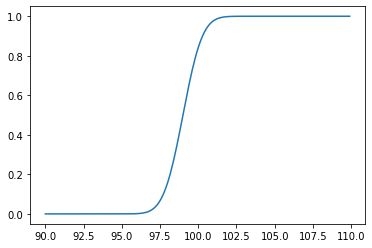

In [14]:
plt.plot( np.arange(90,110, .1), [norm.cdf(x, loc=kwargs['K'], scale=1) for x in np.arange(90,110, .1)])

In [223]:
@jit(nopython=True, fastmath=True)
def Digital_Call_Pathwise(T, K, r, S, sigma, trials, z, sd):
    
    S_adjust = S * np.exp(r - (0.5 * sigma**2)*T)
    delta_array = np.zeros(trials)
    
    for i in range(trials):
        S_cur = S_adjust * np.exp(sigma*np.sqrt(T)*z[i])
        chance = 1/(sd * (np.sqrt(2*math.pi))) * math.e**(-0.5*(((S_cur - K)/sd)**2))
        delta_array[i] = math.e**(-r) * chance * S_cur/S

    return np.mean(delta_array)


def get_delta_digital_pathwise(kwargs):
    z=np.zeros(kwargs['trials'])
    for i in range(kwargs['trials']):
        z[i] = np.random.normal()
        
    kwargs['z'] = z   
    
    delta = Digital_Call_Pathwise(**kwargs)
    
    return delta

In [188]:
kwargs['S'] = 100
get_delta_digital_pathwise(kwargs)

0.01823490407060672

In [190]:
ans = [get_delta_digital_pathwise(kwargs) for x in range(100)]

In [193]:
abs(analytical - np.mean(ans)) / analytical * 100

0.26171184122915303

In [207]:
np.mean(abs(analytical - ans) / analytical * 100)

2.7888852046603048

array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
       6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
       1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
       1.801e+00, 1.901e+00, 2.001e+00, 2.101e+00, 2.201e+00, 2.301e+00,
       2.401e+00, 2.501e+00, 2.601e+00, 2.701e+00, 2.801e+00, 2.901e+00,
       3.001e+00, 3.101e+00, 3.201e+00, 3.301e+00, 3.401e+00, 3.501e+00,
       3.601e+00, 3.701e+00, 3.801e+00, 3.901e+00, 4.001e+00, 4.101e+00,
       4.201e+00, 4.301e+00, 4.401e+00, 4.501e+00, 4.601e+00, 4.701e+00,
       4.801e+00, 4.901e+00])

In [263]:
mean_errors = np.zeros(len(np.arange(.1,5, 0.1)))
total_errors = np.zeros(len(np.arange(.1,5, 0.1)))

kwargs['trials'] = 10**4
for sd in tqdm(np.arange(.1,5, 0.1)):
    kwargs['sd'] = sd
    ans = [get_delta_digital_pathwise(kwargs) for x in range(100)]
    mean_errors[i] = np.mean(abs(analytical - ans) / analytical * 100)
    total_errors[i] = abs(analytical - np.mean(ans)) / analytical *100
    i+=1

100%|█████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:35<00:00,  1.94s/it]


In [264]:
total_errors

array([1.39814756, 0.94393597, 1.17447323, 0.45508036, 0.68876856,
       0.49406829, 0.99123842, 0.18736032, 0.08073665, 0.3990421 ,
       0.2273507 , 0.1058985 , 0.36655067, 0.37735345, 0.05735622,
       0.19957405, 0.44200578, 0.5940542 , 0.67769869, 0.24070018,
       0.41206078, 0.81765038, 0.70614458, 0.90821578, 0.85234546,
       1.26572736, 0.99604912, 0.78828272, 1.08727562, 1.21567603,
       1.17011496, 1.46649687, 1.20528069, 1.36435319, 1.25965969,
       1.82791323, 1.67268748, 2.08100397, 1.93116605, 2.03577119,
       1.8531115 , 2.17881288, 2.22910797, 2.37361407, 2.25473477,
       2.60811007, 2.57701201, 2.54235966, 2.86397327])

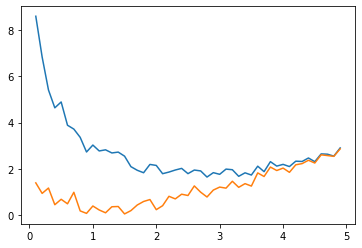

In [266]:
plt.plot(np.arange(.1,5, 0.1), mean_errors)
plt.plot(np.arange(.1,5, 0.1), total_errors)

In [255]:
def pathwise_convergence_matrix(sims, analytical, kwargs):
    ans = Parallel(n_jobs = 10)(delayed(get_delta_digital_pathwise)(kwargs) for i in range(sims))
    return ans

In [275]:
kwargs['sd'] = 1
sizes = [10**4, 10**5, 10**6, 10**7]
experiments = 50
results= []
i = 0
for size in tqdm(sizes):
    kwargs['trials'] = size
    results.append(pathwise_convergence_matrix(experiments, analytical, kwargs))

100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:47<00:00, 56.82s/it]


In [277]:
textfile = open("data/pathwise_results.txt", "w")
for element in results:
    textfile.write(str(element) + "\n")
textfile.close()

In [282]:
ar = np.zeros(3*len(sizes));ar.shape=(len(sizes), 3)

In [283]:
i = 0
for result in results:
    ar[i][0] = np.mean(result)
    ar[i][1] = abs(analytical - np.mean(result)) / analytical *100
    ar[i][2] = np.std(result)/np.sqrt(len(result))
    i+=1

In [284]:
ar

array([[1.81096717e-02, 5.31122350e-01, 1.10609382e-04],
       [1.81920405e-02, 7.87048917e-02, 2.72395759e-05],
       [1.81962524e-02, 5.55704497e-02, 8.97995146e-06],
       [1.81884115e-02, 9.86371728e-02, 2.81344623e-06]])

## Likelihood ratio Method for estimating delta in digital options

In [28]:
def get_delta_likelihood(kwargs):
    S_adjust = kwargs['S'] * np.exp(kwargs['r'] - (0.5 * kwargs['sigma']**2)*kwargs['T'])
    delta_array = np.zeros(kwargs['trials'])

    for i in range(kwargs['trials']):
        Z = np.random.normal()
        S_cur = S_adjust * np.exp(kwargs['sigma']*np.sqrt(kwargs['T'])*Z)
    
        if S_cur > kwargs['K']:
            delta_array[i] = math.e**(-1*kwargs['r']) * Z/(kwargs['sigma']*kwargs['S'])
        else:
            delta_array[i] = 0
        
    return np.mean(delta_array)

def likelihood_convergence_matrix(analytical, kwargs):
    ans = Parallel(n_jobs = 12)(delayed(get_delta_likelihood)(kwargs) for i in range(12))
    return abs(analytical - np.mean(ans)) / analytical * 100

In [29]:
sizes = [10**4, 10**5, 10**6, 10**7]
results = []
for size in sizes:
    kwargs['trials'] = size
    results.append(likelihood_convergence_matrix(analytical, kwargs))

In [30]:
results

[0.2075855564926324,
 0.17566752745374134,
 0.00040262830627694167,
 0.012551890853625168]